In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA

In [2]:
# Declaramos constantes
periodo = 365
USE_CUMSUM = True #En el analisis PCA decidir si se usa demanda acumulada o solo atenciones diarias

macrozona_norte = """(1,2,3,4)"""
macrozona_centro = """(5,6,7,8)"""
region_metropolitana = """(9,10,11,12,13,14)"""
macrozona_centro_sur = """(15,16,17,18,19,20,28)"""
macrozona_sur = """(21,22,23,24,29,33)"""
macrozona_austral = """(25,26)"""

grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]

lista_zonas = ["MacrozonaNorte",
               "MacrozonaCentro",
               "RegionMetropolitana",
               "MacrozonaCentroSur",
               "MacrozonaSur",
               "MacrozonaAustral"]

In [3]:
#Genera una comparación de las atenciones diarias correspondiente 
# a diferentes regiones geográficas. Las zonas están determinadas 
# por lo servicios de salud que las componen
# en los gráficos se muestra la información para diferentes grupos etarios

def common_filter_zona(zona):
    return """
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019)
and CodigoDependencia in """ + zona +"""
group by zona, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'MacrozonaNorte' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(macrozona_norte) + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'MacrozonaCentro' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(macrozona_centro)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'RegionMetropolitana' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(region_metropolitana)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'MacrozonaCentroSur' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(macrozona_centro_sur)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'MacrozonaSur' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(macrozona_sur)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'MacrozonaAustral' as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
"""+ common_filter_zona(macrozona_austral) + """
""").df()

df2 = df2.sort_values(by=['zona','year','nrodia']).reset_index(drop = True)
df3 = pd.concat([df2[["zona","year","nrodia","Menores_1"]].rename(columns={"Menores_1":"atenciones"}).assign(grupo_etario = "Menores_1"),
df2[["zona","year","nrodia","De_1_a_4"]].rename(columns={"De_1_a_4":"atenciones"}).assign(grupo_etario = "De_1_a_4"),
df2[["zona","year","nrodia","De_5_a_14"]].rename(columns={"De_5_a_14":"atenciones"}).assign(grupo_etario = "De_5_a_14"),
df2[["zona","year","nrodia","De_15_a_64"]].rename(columns={"De_15_a_64":"atenciones"}).assign(grupo_etario = "De_15_a_64"),
df2[["zona","year","nrodia","De_65_y_mas"]].rename(columns={"De_65_y_mas":"atenciones"}).assign(grupo_etario = "De_65_y_mas")
])

df2 = df3.sort_values(by=["year","zona","grupo_etario","nrodia"]).reset_index(drop=True)

In [4]:
#the cumulative sum is taken on each of the classes, 
#is this case we group by "year", "CodigoRegion" and "grupo_etario"
#the result is a dataframe with the "nro_dia" in the columns, 
#in which the cumulative information of the demand, scaled from 0 to 1 is stored
groups = df2[["year","zona","grupo_etario"]].drop_duplicates()
df_aux =df2.copy()
for (index, year, zona, grupo_edad) in groups.itertuples():
    indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'zona'] == zona) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
    if sum(indicesToKeep)>0:
        if USE_CUMSUM:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'].cumsum()
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / max(df_aux.loc[indicesToKeep, 'atenciones'])
        else:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / sum(df_aux.loc[indicesToKeep, 'atenciones'])
df3 = df_aux.pivot(index=['year','zona','grupo_etario'],columns= 'nrodia',values='atenciones').reset_index()

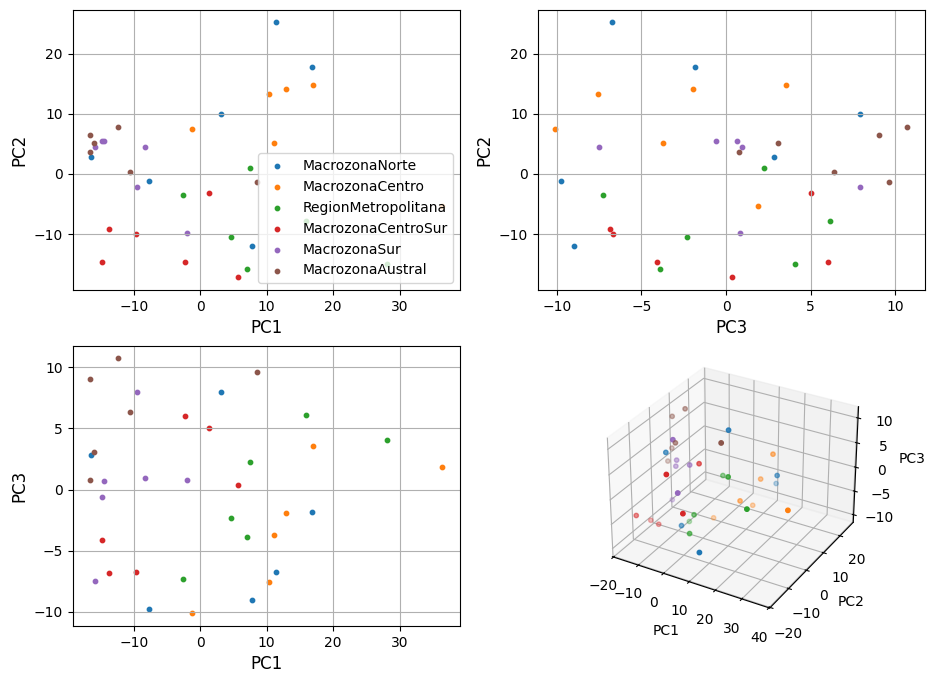

In [5]:
row_filter = []
#for ind in [0,1,2]:
#for ind in [0,1,2,3,4]:
for ind in [3,4]:
    if len(row_filter) == 0:
        row_filter = (df3.loc[:,"grupo_etario"]==grupos_etarios[ind])
    else:
        row_filter = row_filter | (df3.loc[:,"grupo_etario"]==grupos_etarios[ind])

df3 = df3.loc[row_filter,:].reset_index(drop=True)

# Separating out the features
x_original = df3.loc[:, [k+1 for k in range(periodo)]].values

# Separating out the target
y = df3.loc[:,['zona']].values

#Standardizing the features
scaler = StandardScaler().fit(x_original)
x = scaler.transform(x_original)

pca = PCA(n_components=4)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3','PC4'])
finalDf = pd.concat([principalDf, df3[['year','zona','grupo_etario']]], axis = 1)


fig = plt.figure(figsize = (11,8))
ax = fig.add_subplot(2,2,1) 

ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)

#for target, color in zip(targets,colors):
for target in lista_zonas:
    indicesToKeep = finalDf['zona'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 10)
ax.grid()
ax.legend(lista_zonas)
    
ax = fig.add_subplot(2,2,2) 
#ax.set_title('PC1 vs PC3', fontsize = 15)
ax.set_xlabel('PC3', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in lista_zonas:
    indicesToKeep = finalDf['zona'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC3']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 10)
ax.grid()
    
ax = fig.add_subplot(2,2,3) 
#ax.set_title('PC2 vs PC3', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC3', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in lista_zonas:
    indicesToKeep = finalDf['zona'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC3']
               , s = 10)
ax.grid()

#3D PLot of the principal componentes
#fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(2,2,4,projection='3d')

ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in lista_zonas:
    indicesToKeep = finalDf['zona'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , finalDf.loc[indicesToKeep, 'PC3']
               , s = 10)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [6]:
#Short report of the performance of the PCA analysis
print("Percentange of the variance explained by each principal component")
print(pca.explained_variance_ratio_)

Percentange of the variance explained by each principal component
[0.49781738 0.29275848 0.09576668 0.03980875]


In [7]:
#test for a good group in the classification
# here we test the different groupings to check if there 
# are others that make sense, since we test for binary classification 
#and we only have 5 classes it makes sense to consider the groupings
# (1), (2), (3), (4), (5), (1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5),(3,4),(3,5),(4,5)
#those can be presetned in an array and they describe all the possibilities for binary classification


# Declare the group we are trying to separate
maxiter = 100
resultados= np.zeros([maxiter,6,6])

resultados_dic = {}
for iter in range(maxiter):
    for group_indices in [[0], [1], [2], [3], [4], [5],
     [0,1], [0,2], [0,3], [0,4], [0,5], [1,2], [1,3], 
     [1,4], [1,5], [2,3],[2,4], [2,5],[3,4],[3,5],[4,5],
     [0,1,2], [0,1,3], [0,1,4], [0,1,5], [0,2,3], [0,2,4], [0,2,5],
     [0,3,4], [0,3,5], [0,4,5]]:
    #for group_indices in [[0], [1], [2], [3], [4], [0,1], [0,2], [0,3], [0,4], [1,2], [1,3], [1,4],[2,3],[2,4],[3,4]]:
    #for group_indices in [[0,1]]:
        targets = []
        for ind in group_indices:
            if len(targets) == 0:
                targets = (finalDf[["zona"]]==lista_zonas[ind]).values.ravel()
            else:
                targets = targets | (finalDf[["zona"]]==lista_zonas[ind]).values.ravel()
    
        X, y = finalDf[["PC1","PC2","PC3"]].values , targets 
        
        # Split the dataset into a training and a testing set(20 percent)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
        
        # Standarize the features
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # create the linear model SGDclassifier
        linear_clf = SGDClassifier(loss="hinge", alpha=0.000001, max_iter=1000)
        
        # Train the classifier using fit() function
        linear_clf.fit(X_train, y_train)
    
        # Evaluate the result 
        y_train_pred = linear_clf.predict(X_train)
        if len(group_indices)==1:
            resultados[iter, group_indices[0],group_indices[0]] = metrics.accuracy_score(y_train, y_train_pred)
        elif len(group_indices)==2:
            resultados[iter, group_indices[0],group_indices[1]] = metrics.accuracy_score(y_train, y_train_pred)
            resultados[iter, group_indices[1],group_indices[0]] = resultados[iter,group_indices[0],group_indices[1]]
        
        if tuple(group_indices) in resultados_dic.keys():
            resultados_dic[tuple(group_indices)].append(metrics.accuracy_score(y_train, y_train_pred))
        else:
            resultados_dic[tuple(group_indices)]= [metrics.accuracy_score(y_train, y_train_pred)]
        
summary_resultados = {key:np.mean(value) for key, value in resultados_dic.items()}

In [8]:
#summary_resultados

summary_resultados_sorted = sorted(summary_resultados.items(), key=lambda x:-x[1])
pd.DataFrame(summary_resultados_sorted[0:9],columns=["Grouping","accuracy"])


,Grouping,accuracy
0,"(1,)",0.921071
1,"(3,)",0.894286
2,"(1, 2)",0.892500
3,"(0, 1)",0.885000
4,"(0, 1, 2)",0.883929
5,"(2,)",0.833571
6,"(5,)",0.832857
7,"(2, 3)",0.827500
8,"(0, 4, 5)",0.804286


In [9]:
pd.DataFrame(resultados.mean(0),columns=lista_zonas, index = lista_zonas)

,MacrozonaNorte,MacrozonaCentro,RegionMetropolitana,MacrozonaCentroSur,MacrozonaSur,MacrozonaAustral
MacrozonaNorte,0.800714,0.885000,0.643571,0.641071,0.628214,0.732143
MacrozonaCentro,0.885000,0.921071,0.892500,0.686429,0.621786,0.648571
RegionMetropolitana,0.643571,0.892500,0.833571,0.827500,0.597500,0.634286
MacrozonaCentroSur,0.641071,0.686429,0.827500,0.894286,0.700357,0.755000
MacrozonaSur,0.628214,0.621786,0.597500,0.700357,0.730000,0.803929
MacrozonaAustral,0.732143,0.648571,0.634286,0.755000,0.803929,0.832857
